# **Lab 9.1 Generative Adversarial Network**
**NOTE :** Use the dataset from lab5.

In [1]:
import torch
from torch import nn
from tqdm import tqdm
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import os

## Architecture
Complete the GAN architecture that generates RGB images of size 128x128.

In [2]:
### START CODE HERE ###

class Generator(nn.Module):
    def __init__(self, z_dim=100, im_ch=3, hidden_dim=1024):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self.conv_block(z_dim, hidden_dim, kernel_size=4, stride=1, padding=0),
            self.conv_block(hidden_dim, hidden_dim//2, kernel_size=4, stride=2, padding=1),
            self.conv_block(hidden_dim//2, hidden_dim//4, kernel_size=4, stride=2, padding=1),
            self.conv_block(hidden_dim//4, hidden_dim//8, kernel_size=4, stride=2, padding=1),
            self.conv_block(hidden_dim//8, hidden_dim//16, kernel_size=4, stride=2, padding=1),
            self.conv_block(hidden_dim//16, im_ch, kernel_size=4, stride=2, padding=1, final_layer=True)
        )

    def conv_block(self, in_ch, out_ch, kernel_size=4, stride=2, padding=1, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(0.2)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.Tanh()
            )

    def forward(self, noise):
        noise = noise.view(noise.size(0), noise.size(1), 1, 1)
        return self.gen(noise)

### END CODE HERE ###

In [3]:
### START CODE HERE ###

class Discriminator(nn.Module):
    def __init__(self,im_ch=3, hidden_dim=32):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.conv_block(im_ch, hidden_dim, kernel_size=4, stride=2, padding=1),
            self.conv_block(hidden_dim, hidden_dim*2, kernel_size=4, stride=2, padding=1),
            self.conv_block(hidden_dim*2, hidden_dim*4, kernel_size=4, stride=2, padding=1),
            self.conv_block(hidden_dim*4, hidden_dim*8, kernel_size=4, stride=2, padding=1),
            self.conv_block(hidden_dim*8, 1, kernel_size=4, stride=2, padding=0, final_layer=True)
        )

    def conv_block(self, in_ch, out_ch, kernel_size=4, stride=2, padding=1, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.Sigmoid()
            )

    def forward(self, image):
        return self.disc(image).view(-1)

### END CODE HERE ###

Complete the function below. The `get_noise` function generates a random noise tensor that is typically used as input to a Generator
- `n_sample`: The number of noise samples to generate.

- `z_dim`: The dimensionality of each noise vector.

- `device`: The device on which the tensor will be allocated. By default, it is set to 'cuda'

In [4]:
### START CODE HERE ###

def get_noise(n_sample, z_dim, device='cuda'):
    return torch.randn(n_sample, z_dim, device=device)

### END CODE HERE ###

In [5]:
n_sample = 25
z_dim = 100
noise = get_noise(n_sample, z_dim)
assert noise.shape == (n_sample, z_dim), f"Expected shape {(n_sample, z_dim)}, but got {noise.shape}"

noise_cpu = get_noise(n_sample, z_dim, device='cpu')
assert noise_cpu.device.type == 'cpu', f"Expected tensor to be on 'cpu', but got {noise_cpu.device.type}"
assert noise.dtype == torch.float32, f"Expected dtype to be torch.float32, but got {noise.dtype}"

## Preparation
Prepare all training components such as the dataset, batch size, optimizer, and model, etc. No need to perform a train-test split.

In [6]:
### START CODE HERE ###

device = 'cuda' if torch.cuda.is_available() else 'cpu'

path = r'C:\Users\Nickv\Documents\ImageProcessing\Week5\images'

transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])    

generator = Generator().to(device)
discriminator = Discriminator().to(device)

dataset = datasets.ImageFolder(root=path, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

gen_opt = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))

### END CODE HERE ###

Display first batch of dataset.

In [7]:
def imshow_grid(batch):

    batch = batch.numpy()
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))

    for i in range(16):
        image = np.transpose(batch[i], (1, 2, 0))
        image = (image + 1) / 2

        ax = axes[i // 4, i % 4]
        ax.imshow(image)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

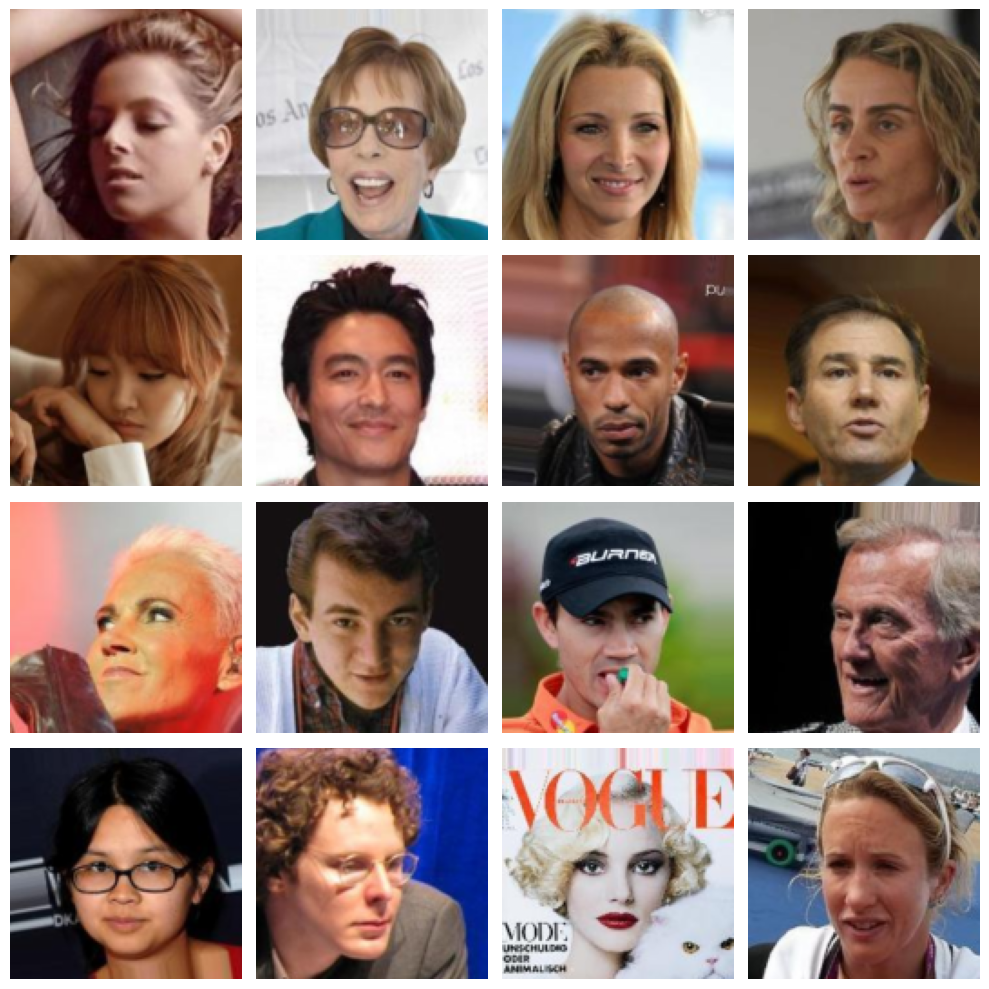

In [8]:
### START CODE HERE ###

images, labels = next(iter(dataloader))
imshow_grid(images)

### END CODE HERE ###

Use `get_noise` to generate noise with 25 samples, and then use the generator to generate images with that noise.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab9_GAN/assets/1.png?raw=true)


</details>

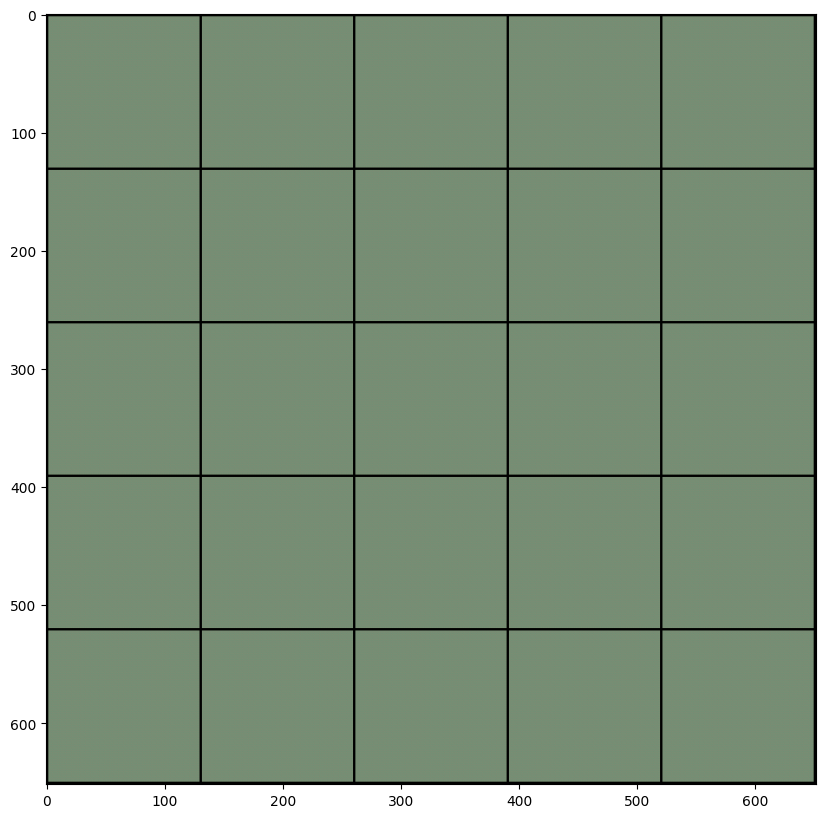

In [9]:
### START CODE HERE ###

with torch.no_grad():
    generator.eval()
    fake_images = generator(noise).cuda()

def show_images(images, nrow=5):
    images = images.cpu()
    images = (images + 1) / 2
    grid_img = torchvision.utils.make_grid(images, nrow=nrow)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(grid_img.numpy(), (1, 2, 0)))
    plt.show()

show_images(fake_images)

### END CODE HERE ###

Complete the training function that trains and logs the average loss for both the generator and discriminator, and generates sample images at each epoch (using the same input vector as the previous part) to [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html).
<details>
<summary>
<font size="3" color="orange">
<b>Expected output in tensorboard</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab9_GAN/assets/2.png?raw=true)


</details>


In [10]:
### START CODE HERE ###
def train(generator, discriminator, gen_opt, disc_opt, criterion, dataloader, test_noise, z_dim, epochs=10, writer=None, checkpoint_path=None, device='cuda'):
    print("🤖 Training on", device)
    generator.to(device)
    discriminator.to(device)

    for epoch in range(epochs):
        gen_loss_avg = 0
        disc_loss_avg = 0
        num_batches = len(dataloader)
        train_bar = tqdm(dataloader, desc=f'🚀 Training Epoch [{epoch+1}/{epochs}]', unit='batch')

        for real_images, _ in train_bar:
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            disc_opt.zero_grad()

            noise = torch.randn(batch_size, z_dim, device=device)
            fake_images = generator(noise)

            real_pred = discriminator(real_images)
            fake_pred = discriminator(fake_images.detach())
            real_loss = criterion(real_pred, torch.ones_like(real_pred))
            fake_loss = criterion(fake_pred, torch.zeros_like(fake_pred))
            disc_loss = (real_loss + fake_loss) / 2

            disc_loss.backward()
            disc_opt.step()

            gen_opt.zero_grad()

            fake_pred = discriminator(fake_images)
            gen_loss = criterion(fake_pred, torch.ones_like(fake_pred))

            gen_loss.backward()
            gen_opt.step()

            gen_loss_avg += gen_loss.item() / num_batches
            disc_loss_avg += disc_loss.item() / num_batches

        if writer:
            writer.add_scalar('Generator Loss', gen_loss_avg, epoch)
            writer.add_scalar('Discriminator Loss', disc_loss_avg, epoch)

        with torch.no_grad():
            generator.eval()
            fake_images_test = generator(test_noise.to(device))

            img_grid = torchvision.utils.make_grid(fake_images_test, nrow=5)
            if writer:
                writer.add_image('Generated Images', img_grid, epoch)

            generator.train()

        if checkpoint_path:
            torch.save({
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'gen_opt_state_dict': gen_opt.state_dict(),
                'disc_opt_state_dict': disc_opt.state_dict(),
                'epoch': epoch
            }, f"{checkpoint_path}/gan_checkpoint_epoch_{epoch}.pth")

        print(f'Epoch {epoch+1}, Generator loss: {gen_loss_avg:.4f}, Discriminator loss: {disc_loss_avg:.4f}')

### END CODE HERE ###

In [11]:
### START CODE HERE ###

device = 'cuda' if torch.cuda.is_available() else 'cpu'

generator = Generator(z_dim=100).to(device)
discriminator = Discriminator(im_ch=3).to(device)

gen_opt = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

criterion = nn.BCELoss()

dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

test_noise = torch.randn(25, 100).to(device)

writer = SummaryWriter(log_dir='runs/gan_experiments')

train(generator, discriminator, gen_opt, disc_opt, criterion, dataloader, test_noise, z_dim=100, epochs=30, writer=writer, checkpoint_path=r'C:\Users\Nickv\Documents\ImageProcessing\Week9\models\model', device=device)

writer.close()

### END CODE HERE ###

🤖 Training on cuda


🚀 Training Epoch [1/30]: 100%|██████████| 1875/1875 [04:04<00:00,  7.68batch/s]


Epoch 1, Generator loss: 2.4098, Discriminator loss: 0.2920


🚀 Training Epoch [2/30]: 100%|██████████| 1875/1875 [01:26<00:00, 21.67batch/s]


Epoch 2, Generator loss: 1.7146, Discriminator loss: 0.4972


🚀 Training Epoch [3/30]: 100%|██████████| 1875/1875 [01:26<00:00, 21.65batch/s]


Epoch 3, Generator loss: 1.5112, Discriminator loss: 0.5127


🚀 Training Epoch [4/30]: 100%|██████████| 1875/1875 [01:25<00:00, 21.99batch/s]


Epoch 4, Generator loss: 1.5805, Discriminator loss: 0.4816


🚀 Training Epoch [5/30]: 100%|██████████| 1875/1875 [01:27<00:00, 21.50batch/s]


Epoch 5, Generator loss: 1.6198, Discriminator loss: 0.4807


🚀 Training Epoch [6/30]: 100%|██████████| 1875/1875 [01:28<00:00, 21.17batch/s]


Epoch 6, Generator loss: 1.5165, Discriminator loss: 0.5043


🚀 Training Epoch [7/30]: 100%|██████████| 1875/1875 [01:24<00:00, 22.27batch/s]


Epoch 7, Generator loss: 1.4435, Discriminator loss: 0.5270


🚀 Training Epoch [8/30]: 100%|██████████| 1875/1875 [01:25<00:00, 21.90batch/s]


Epoch 8, Generator loss: 1.3924, Discriminator loss: 0.5364


🚀 Training Epoch [9/30]: 100%|██████████| 1875/1875 [01:26<00:00, 21.60batch/s]


Epoch 9, Generator loss: 1.3152, Discriminator loss: 0.5602


🚀 Training Epoch [10/30]: 100%|██████████| 1875/1875 [01:26<00:00, 21.77batch/s]


Epoch 10, Generator loss: 1.2663, Discriminator loss: 0.5680


🚀 Training Epoch [11/30]: 100%|██████████| 1875/1875 [01:23<00:00, 22.43batch/s]


Epoch 11, Generator loss: 1.2827, Discriminator loss: 0.5683


🚀 Training Epoch [12/30]: 100%|██████████| 1875/1875 [01:23<00:00, 22.46batch/s]


Epoch 12, Generator loss: 1.2393, Discriminator loss: 0.5763


🚀 Training Epoch [13/30]: 100%|██████████| 1875/1875 [01:25<00:00, 21.81batch/s]


Epoch 13, Generator loss: 1.2455, Discriminator loss: 0.5735


🚀 Training Epoch [14/30]: 100%|██████████| 1875/1875 [01:25<00:00, 21.91batch/s]


Epoch 14, Generator loss: 1.2638, Discriminator loss: 0.5715


🚀 Training Epoch [15/30]: 100%|██████████| 1875/1875 [01:25<00:00, 21.92batch/s]


Epoch 15, Generator loss: 1.2666, Discriminator loss: 0.5690


🚀 Training Epoch [16/30]: 100%|██████████| 1875/1875 [01:26<00:00, 21.78batch/s]


Epoch 16, Generator loss: 1.2697, Discriminator loss: 0.5709


🚀 Training Epoch [17/30]: 100%|██████████| 1875/1875 [01:25<00:00, 21.86batch/s]


Epoch 17, Generator loss: 1.2943, Discriminator loss: 0.5626


🚀 Training Epoch [18/30]: 100%|██████████| 1875/1875 [01:26<00:00, 21.65batch/s]


Epoch 18, Generator loss: 1.3137, Discriminator loss: 0.5565


🚀 Training Epoch [19/30]: 100%|██████████| 1875/1875 [01:29<00:00, 20.93batch/s]


Epoch 19, Generator loss: 1.3248, Discriminator loss: 0.5541


🚀 Training Epoch [20/30]: 100%|██████████| 1875/1875 [01:27<00:00, 21.39batch/s]


Epoch 20, Generator loss: 1.3361, Discriminator loss: 0.5490


🚀 Training Epoch [21/30]: 100%|██████████| 1875/1875 [01:25<00:00, 21.85batch/s]


Epoch 21, Generator loss: 1.3593, Discriminator loss: 0.5475


🚀 Training Epoch [22/30]: 100%|██████████| 1875/1875 [01:26<00:00, 21.65batch/s]


Epoch 22, Generator loss: 1.3590, Discriminator loss: 0.5450


🚀 Training Epoch [23/30]: 100%|██████████| 1875/1875 [01:27<00:00, 21.45batch/s]


Epoch 23, Generator loss: 1.3931, Discriminator loss: 0.5351


🚀 Training Epoch [24/30]: 100%|██████████| 1875/1875 [01:26<00:00, 21.62batch/s]


Epoch 24, Generator loss: 1.3995, Discriminator loss: 0.5378


🚀 Training Epoch [25/30]: 100%|██████████| 1875/1875 [01:26<00:00, 21.68batch/s]


Epoch 25, Generator loss: 1.4059, Discriminator loss: 0.5319


🚀 Training Epoch [26/30]: 100%|██████████| 1875/1875 [01:27<00:00, 21.52batch/s]


Epoch 26, Generator loss: 1.4490, Discriminator loss: 0.5228


🚀 Training Epoch [27/30]: 100%|██████████| 1875/1875 [01:27<00:00, 21.49batch/s]


Epoch 27, Generator loss: 1.4479, Discriminator loss: 0.5257


🚀 Training Epoch [28/30]: 100%|██████████| 1875/1875 [01:25<00:00, 21.81batch/s]


Epoch 28, Generator loss: 1.4573, Discriminator loss: 0.5235


🚀 Training Epoch [29/30]: 100%|██████████| 1875/1875 [01:25<00:00, 21.89batch/s]


Epoch 29, Generator loss: 1.4719, Discriminator loss: 0.5238


🚀 Training Epoch [30/30]: 100%|██████████| 1875/1875 [01:28<00:00, 21.16batch/s]


Epoch 30, Generator loss: 1.4893, Discriminator loss: 0.5127


Test Genereate the image.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab9_GAN/assets/3.png?raw=true)


</details>

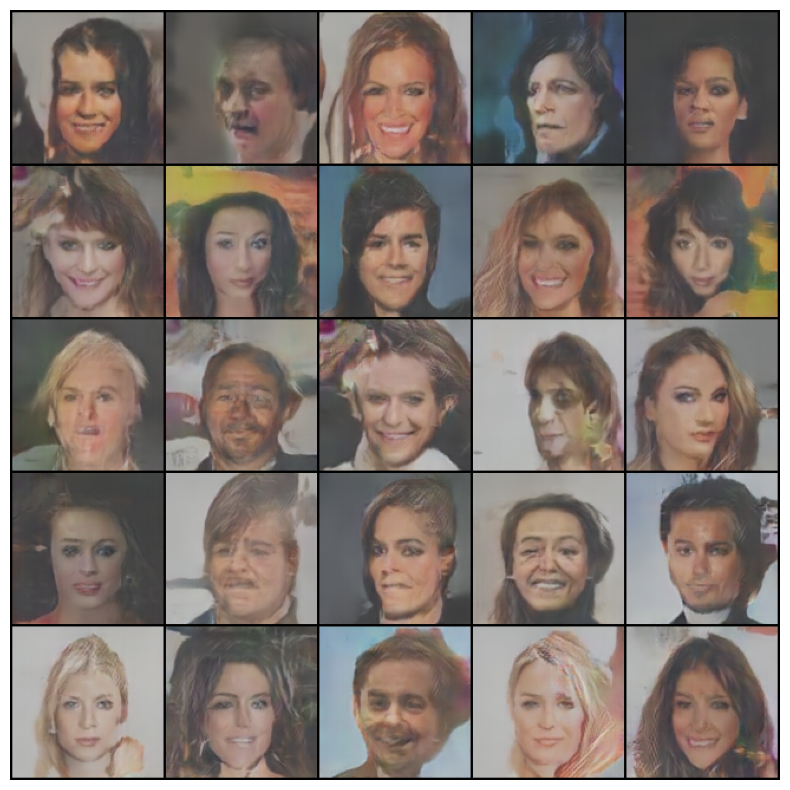

In [170]:
### START CODE HERE ###

def generate_and_display_grid(generator, z_dim, grid_size=(5, 5), device='cuda'):
    generator.eval()

    noise = torch.randn(grid_size[0] * grid_size[1], z_dim, device=device)

    with torch.no_grad():
        fake_images = generator(noise).cpu()

    fake_images = (fake_images + 1) / 2

    img_grid = torchvision.utils.make_grid(fake_images, nrow=grid_size[1])
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img_grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

generate_and_display_grid(generator, z_dim=100)

### END CODE HERE ###

---

# Question
1. In the architecture of a discriminator, if the last layer is not a fully connected layer and the output is in a 3D tensor format rather than a 1D vector, how would you compute the Binary Cross-Entropy Loss (BCELoss) in this case?

2. If the architecture of the generator includes one or more hidden fully connected layers before the output layer, how would this affect the quality or characteristics of the generated output? 

3. When alternating between training the generator and the discriminator in a GAN, at which level should this switching occur to achieve optimal results—should it be done at the epoch level, the iteration level, or the batch level?